In [181]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math
from itertools import combinations
import matplotlib.pyplot as plt

# A. Explore relationship betwen forex pair movements etc yada yada

OK so this is not exaclty forex pairs because it seems to be a pain in the ass to find one, but i think the intuition for this one is quite solid

1. SGD is pegged against a basket of currencies (S$NEER), https://www.mas.gov.sg/monetary-policy/past-monetary-policy-decisions
2. DXY is an index that measures the USD value relative to a basket of currencies https://www.investopedia.com/terms/u/usdx.asp

fucking money laundering ccy

Essentially this is basket meet basket kind of thing. "ETF" pairs trading if you will.

USD-SGD is tradeable, and so is DXY. Prof Ben say pairs trading does not have to be same asset class, so this COULD be legit

Anyway general steps 

1. test your series (plural) are cointegrated or not
2. test your spread is stationary or not
3. generate trading signal

Possible improvement can be done for the regression part to obtain the weights. Right now we are using OLS and probably can be changed

In [182]:
start_date = "2023-01-01"
end_date = "2024-05-31"

In [183]:
# get close data
usd_sgd_data = yf.Ticker("USDSGD=X").history(start=start_date, end=end_date, interval = "1h")["Close"]
dxy_data = yf.Ticker("DX-Y.NYB").history(start=start_date, end=end_date, interval = "1h")["Close"]

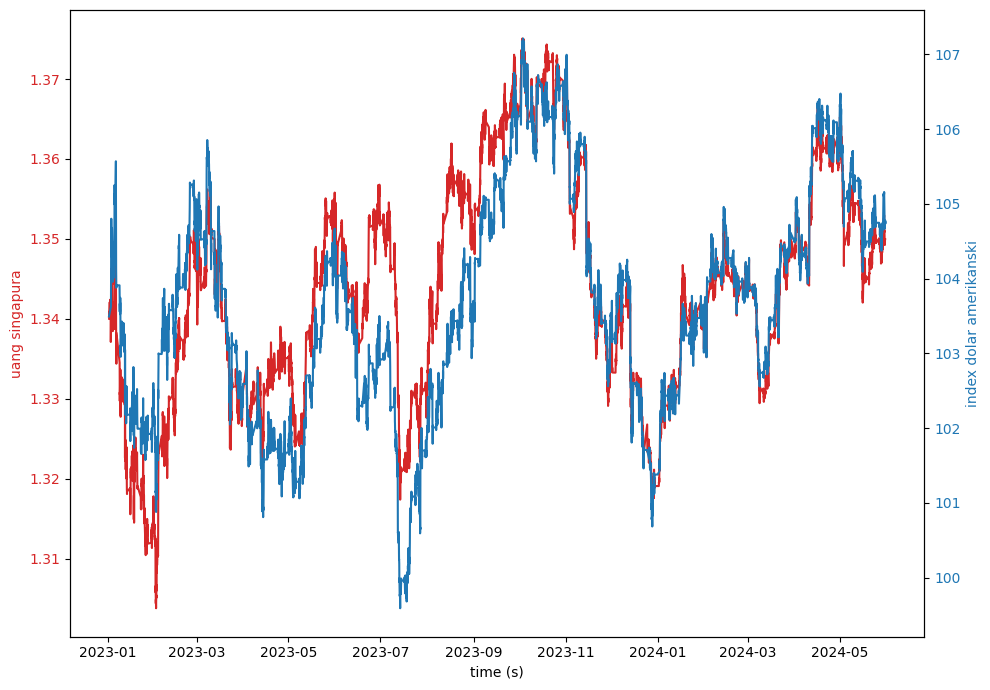

In [184]:
fig, ax1 = plt.subplots(figsize=(10, 7))
color = "tab:red"
ax1.set_xlabel("time (s)")
ax1.set_ylabel("uang singapura", color=color)
ax1.plot(usd_sgd_data, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("index dolar amerikanski", color=color)  # we already handled the x-label with ax1
ax2.plot(dxy_data, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [185]:
df_together = pd.DataFrame(
    zip(usd_sgd_data, dxy_data), index=dxy_data.index, columns=["usdsgd", "dxy"]
)
df_together

,usdsgd,dxy
Datetime,,
2023-01-01 17:00:00-05:00,1.34002,103.494003
2023-01-03 00:00:00-05:00,1.34017,103.624001
2023-01-03 01:00:00-05:00,1.34011,103.695999
2023-01-03 02:00:00-05:00,1.34045,103.933998
2023-01-03 03:00:00-05:00,1.34054,104.623001
...,...,...
2024-05-30 17:00:00-04:00,1.34538,104.739998
2024-05-30 18:00:00-04:00,1.34518,104.741997
2024-05-30 19:00:00-04:00,1.34542,104.776001


In [186]:
return_df = (df_together / df_together.shift(1)) - 1
return_df

,usdsgd,dxy
Datetime,,
2023-01-01 17:00:00-05:00,NaN,NaN
2023-01-03 00:00:00-05:00,0.000112,0.001256
2023-01-03 01:00:00-05:00,-0.000045,0.000695
2023-01-03 02:00:00-05:00,0.000254,0.002295
2023-01-03 03:00:00-05:00,0.000067,0.006629
...,...,...
2024-05-30 17:00:00-04:00,-0.000965,-0.000086
2024-05-30 18:00:00-04:00,-0.000149,0.000019
2024-05-30 19:00:00-04:00,0.000178,0.000325


## Test for Cointegration
Using the ts.coint function, we are using the Engle-Gragner test
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html

I think the way to read the result is you compare tour test statistic with the crit values. 

If your test statistic is smaller than the crit value for that significance level, then your series (plural) are cointegrated up to that significance level

e.g. test statistic = -3.5, crit value for 5% significance = -3.3
your series(plural) are coint with 5% significance level

In [187]:
train_start = 0
train_end = math.floor(0.8 * len(df_together))
oos_start = train_end + 1
oos_end = len(df_together) - 1
splitidx = df_together.iloc[train_end].name

In [188]:
training = df_together[train_start:train_end]
oos = df_together[oos_start:oos_end]
training

,usdsgd,dxy
Datetime,,
2023-01-01 17:00:00-05:00,1.34002,103.494003
2023-01-03 00:00:00-05:00,1.34017,103.624001
2023-01-03 01:00:00-05:00,1.34011,103.695999
2023-01-03 02:00:00-05:00,1.34045,103.933998
2023-01-03 03:00:00-05:00,1.34054,104.623001
...,...,...
2024-02-21 01:00:00-05:00,1.34343,104.033997
2024-02-21 02:00:00-05:00,1.34233,104.042999
2024-02-21 03:00:00-05:00,1.34249,104.163002


In [189]:
# lets do it
coint_result = ts.coint(training["usdsgd"], training["dxy"])
print(f"test statistic = {coint_result[0]}")
print(
    f"crit values (from left to right 1%, 5%, 10% significance level)= {coint_result[2]}"
)

test statistic = -4.592479269569272
crit values (from left to right 1%, 5%, 10% significance level)= [-3.89805082 -3.33702843 -3.04507358]


## Prof Ben's Cointegration

/tmp/ipykernel_3696/757611729.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training["spread"] = y - gamma * x


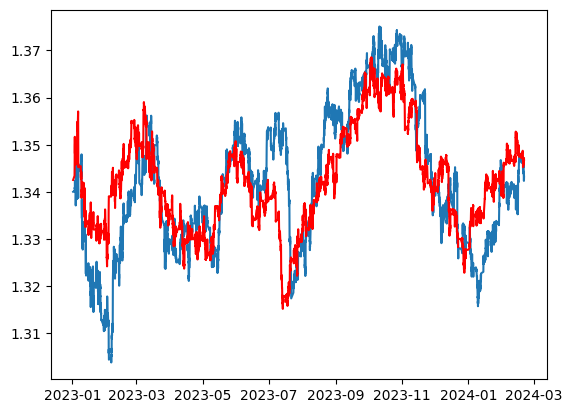

In [190]:
y = training["usdsgd"]  # usdsgd
x = training["dxy"]  # dxy
result = sm.OLS(y.to_numpy(), sm.tools.add_constant(x.to_numpy())).fit()

mu = result.params[0]
gamma = result.params[1]
# print model vs actual
training["spread"] = y - gamma * x
model = gamma * x + mu
plt.plot(y)
plt.plot(model, color="red")

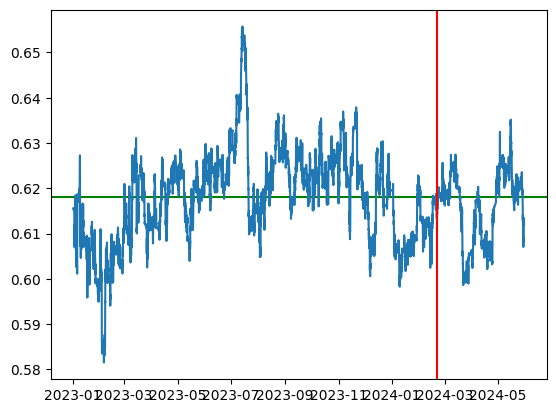

In [191]:
# spread, idk why prof ben coded it like this
y_all = df_together["usdsgd"]  # usdsgd
x_all = df_together["dxy"]  # dxy


df_together["spread"] = y_all - gamma * x_all
plt.axhline(np.mean(y - gamma * x), color="green")
plt.plot(df_together["spread"])
plt.axvline(splitidx, color="red")

### Note regarding stationarity test

if your test statistic is smaller than critical value for a corresponding significance level, means your series is stationary up to that significance level

e.g. test_statistic = -3.5, 1% significance critval = - 3.3 
your series is stationary with significane level of 99%

another thing to check is p value
p value > 0.05 ; accept null & your series is NOT stationary
p value < 0.05 ; reject null hypothesis & your series IS STATIONARY

In [192]:
result_adf = ts.adfuller(training["spread"])
print(f"test statistic {result_adf[0]}")
print(f"p value {result_adf[1]}")
print(f"critical values for test statistic {result_adf[4]}")

test statistic -4.592165460322621
p value 0.0001335333727243742
critical values for test statistic {'1%': -3.431313158592296, '5%': -2.8619656366679043, '10%': -2.566996562658244}


## ok now we actually do the portfolio

In [193]:
normport = [1, -gamma] / (1 + gamma)
df_together_weighted = normport * df_together[["usdsgd", "dxy"]]
df_together_weighted["spread"] = (
    df_together_weighted["usdsgd"] + df_together_weighted["dxy"]
)

In [194]:
weight_train_mean = np.mean(df_together_weighted[train_start:train_end]["spread"])
weight_train_std = np.std(df_together_weighted[train_start:train_end]["spread"], ddof=1)

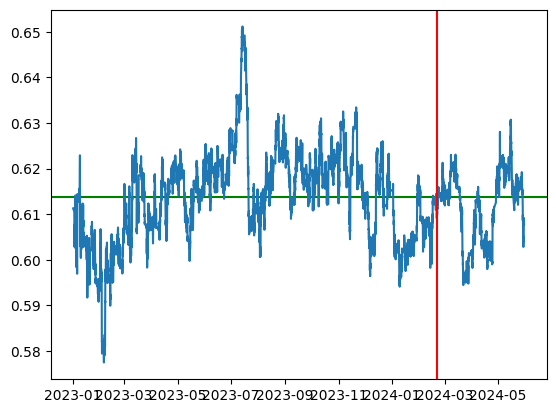

In [195]:
plt.axhline(weight_train_mean, color="green")
plt.plot(df_together_weighted["spread"])
plt.axvline(splitidx, color="red")

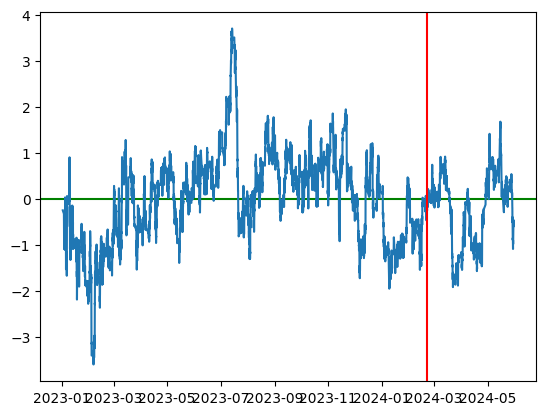

In [196]:
df_z = (df_together_weighted["spread"] - weight_train_mean) / weight_train_std
plt.axhline(0, color="green")
plt.plot(df_z)
plt.axvline(splitidx, color="red")
# plt.axhline(weight_train_std, color="green")